In [1]:
import os
import h5py
import tkinter
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from scipy import signal
from data_import import import_ppd

### Process single PPD file

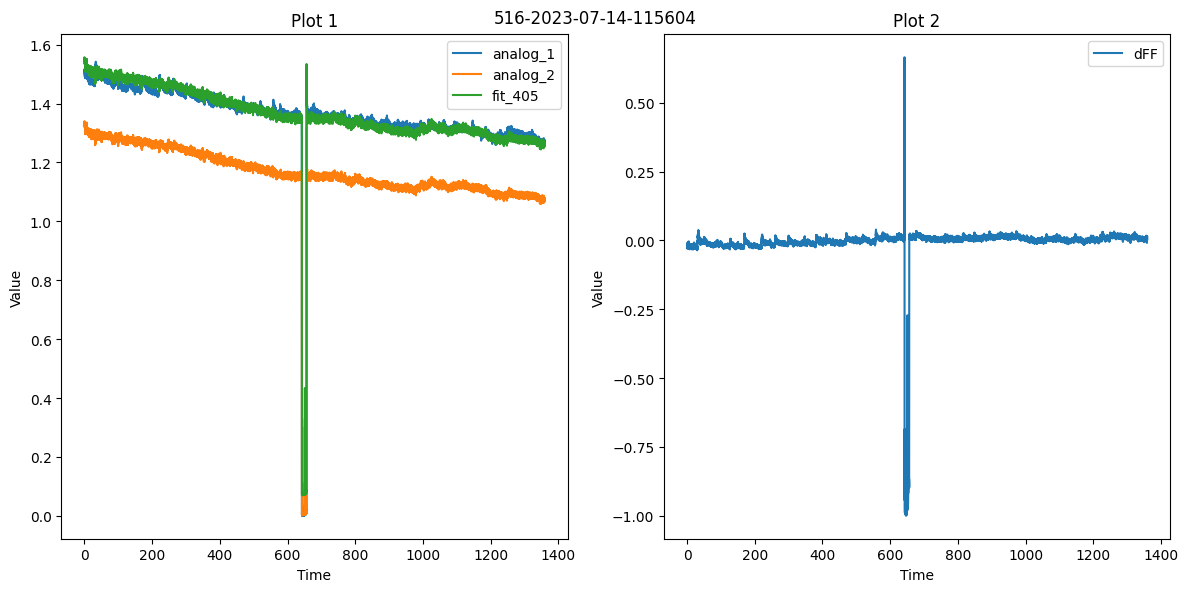

In [20]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\516-2023-07-14-115604.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


In [21]:
data = {
    'UniBe004': 
            {'Stim': [1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 1, 0], 
             'Time': ['00:30', '01:29', '02:07', '02:48', '03:39', '04:19', '04:59', '05:46', '06:20', '06:50', 
                      '07:49', '08:38', '09:37', '10:19', '11:16', '12:03', '12:42', '13:34', '14:08', '14:53', 
                      '15:25', '16:12', '16:56', '17:41', '18:11', '19:06', '19:43', '20:27', '21:02', '22:02']}
}

stim_data = data['UniBe004']['Stim']
time_stamps = data['UniBe004']['Time']
sampling_rate = 130

def time_stamp_to_seconds(time_stamp):
    minutes, seconds = time_stamp.split(':')
    return int(minutes) * 60 + int(seconds)

water_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
tmt_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]

water_time_stamps = [time_stamps[i] for i in water_indexes]
tmt_time_stamps = [time_stamps[i] for i in tmt_indexes]

water_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in water_time_stamps]
tmt_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in tmt_time_stamps]

print("Water Indexes:", water_indexes)
print("Water Time Stamps:", water_time_stamps)
print("Water Data Indexes:", water_data_indexes)

print("TMT Indexes:", tmt_indexes)
print("TMT Time Stamps:", tmt_time_stamps)
print("TMT Data Indexes:", tmt_data_indexes)


Water Indexes: [1, 2, 7, 9, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 29]
Water Time Stamps: ['01:29', '02:07', '05:46', '06:50', '12:03', '12:42', '13:34', '14:08', '14:53', '16:12', '16:56', '17:41', '18:11', '19:06', '22:02']
Water Data Indexes: [11570, 16510, 44980, 53300, 93990, 99060, 105820, 110240, 116090, 126360, 132080, 137930, 141830, 148980, 171860]
TMT Indexes: [0, 3, 4, 5, 6, 8, 10, 11, 12, 13, 14, 20, 26, 27, 28]
TMT Time Stamps: ['00:30', '02:48', '03:39', '04:19', '04:59', '06:20', '07:49', '08:38', '09:37', '10:19', '11:16', '15:25', '19:43', '20:27', '21:02']
TMT Data Indexes: [3900, 21840, 28470, 33670, 38870, 49400, 60970, 67340, 75010, 80470, 87880, 120250, 153790, 159510, 164060]


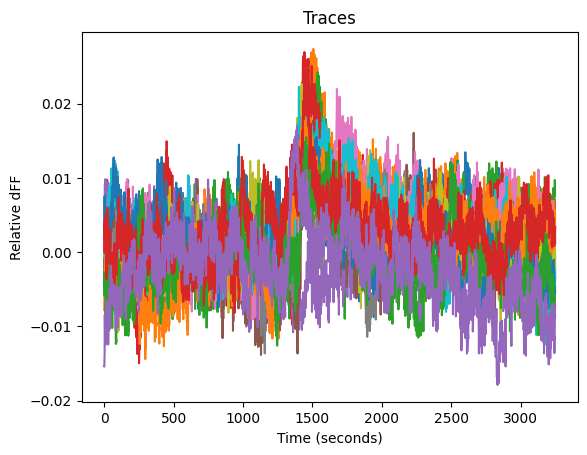

In [22]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in water_data_indexes:
    pre_start = 10
    post_start = 15
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_water = np.array(trace_data_matrix)


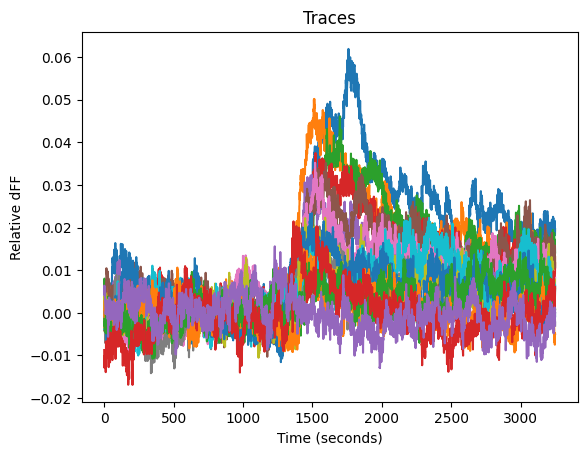

In [23]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in tmt_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_tmt = np.array(trace_data_matrix)


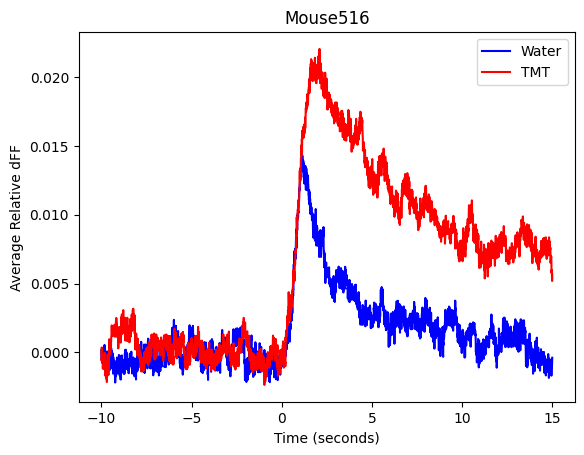

In [24]:
# Calculate the average trace for water and TMT
average_trace_water = np.mean(trace_data_matrix_water, axis=0)
average_trace_tmt = np.mean(trace_data_matrix_tmt, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water, label='Water', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt, label='TMT', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse516')
plt.legend()
plt.show()

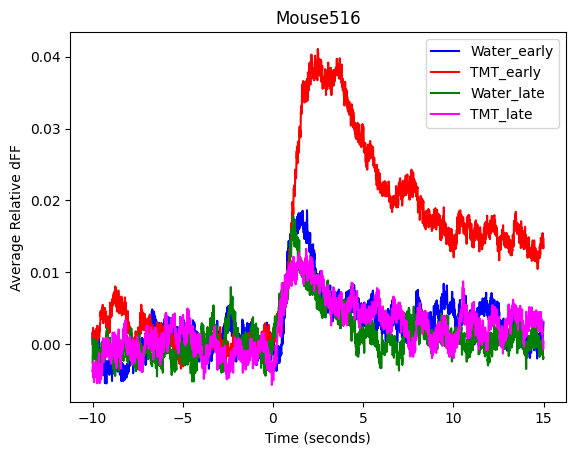

In [25]:
# Calculate the average trace for water and TMT
average_trace_water_early = np.mean(trace_data_matrix_water[0:4,:], axis=0)
average_trace_tmt_early = np.mean(trace_data_matrix_tmt[0:4,:], axis=0)
average_trace_water_late = np.mean(trace_data_matrix_water[10:14,:], axis=0)
average_trace_tmt_late = np.mean(trace_data_matrix_tmt[10:14,:], axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_early, label='Water_early', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_early, label='TMT_early', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_late, label='Water_late', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_late, label='TMT_late', color='magenta')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse516')
plt.legend()
plt.show()

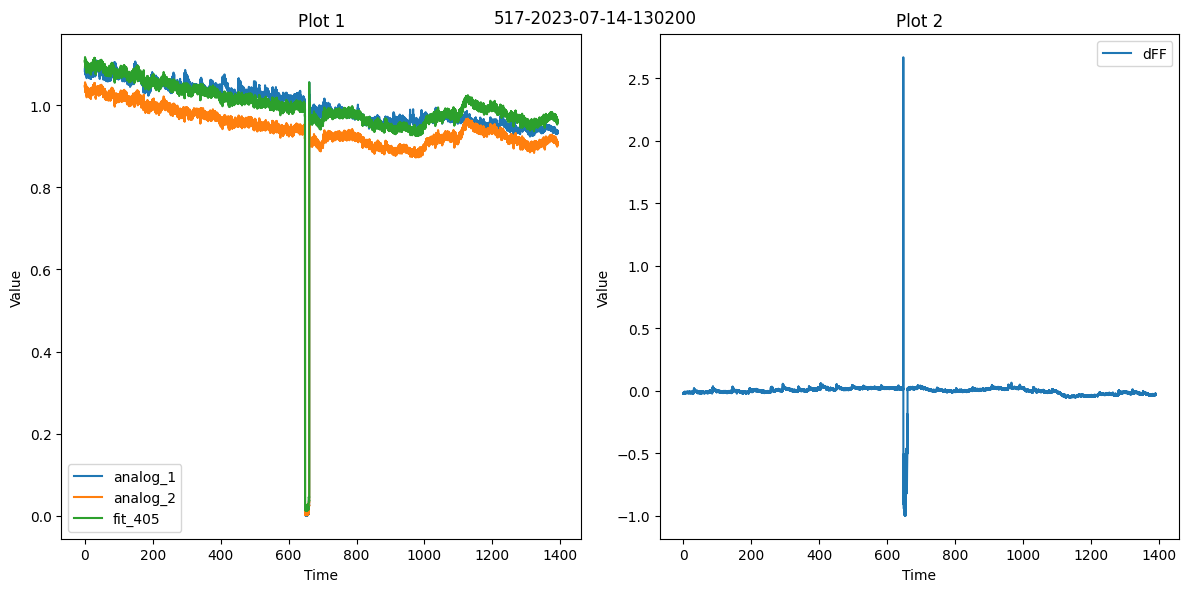

In [26]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\517-2023-07-14-130200.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


In [27]:
data = {
    'UniBe005': 
            {'Stim': [1, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0] ,
            'Time': ['00:30', '01:25', '02:24', '03:12', '03:45', '04:17', '04:52', '05:38', '06:09', '06:44', 
                    '07:30', '08:17', '08:49', '09:42', '10:31', '11:30', '12:26', '13:23', '14:11', '15:08', 
                    '15:57', '16:30', '17:10', '18:06', '18:39', '19:33', '20:25', '21:21', '22:01', '22:34'] }
}

stim_data = data['UniBe005']['Stim']
time_stamps = data['UniBe005']['Time']
sampling_rate = 130

def time_stamp_to_seconds(time_stamp):
    minutes, seconds = time_stamp.split(':')
    return int(minutes) * 60 + int(seconds)

water_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
tmt_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]

water_time_stamps = [time_stamps[i] for i in water_indexes]
tmt_time_stamps = [time_stamps[i] for i in tmt_indexes]

water_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in water_time_stamps]
tmt_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in tmt_time_stamps]

print("Water Indexes:", water_indexes)
print("Water Time Stamps:", water_time_stamps)
print("Water Data Indexes:", water_data_indexes)

print("TMT Indexes:", tmt_indexes)
print("TMT Time Stamps:", tmt_time_stamps)
print("TMT Data Indexes:", tmt_data_indexes)


Water Indexes: [1, 4, 6, 7, 9, 12, 15, 16, 17, 20, 21, 22, 24, 26, 29]
Water Time Stamps: ['01:25', '03:45', '04:52', '05:38', '06:44', '08:49', '11:30', '12:26', '13:23', '15:57', '16:30', '17:10', '18:39', '20:25', '22:34']
Water Data Indexes: [11050, 29250, 37960, 43940, 52520, 68770, 89700, 96980, 104390, 124410, 128700, 133900, 145470, 159250, 176020]
TMT Indexes: [0, 2, 3, 5, 8, 10, 11, 13, 14, 18, 19, 23, 25, 27, 28]
TMT Time Stamps: ['00:30', '02:24', '03:12', '04:17', '06:09', '07:30', '08:17', '09:42', '10:31', '14:11', '15:08', '18:06', '19:33', '21:21', '22:01']
TMT Data Indexes: [3900, 18720, 24960, 33410, 47970, 58500, 64610, 75660, 82030, 110630, 118040, 141180, 152490, 166530, 171730]


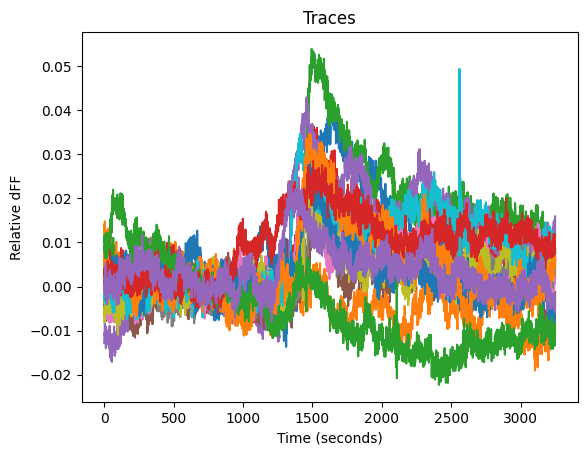

In [28]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in water_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_water = np.array(trace_data_matrix)


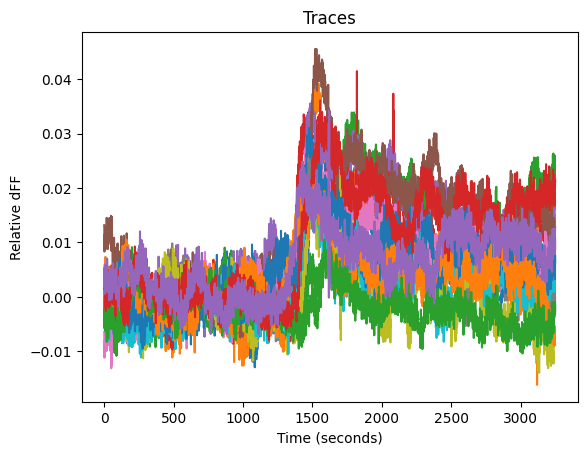

In [29]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in tmt_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_tmt = np.array(trace_data_matrix)


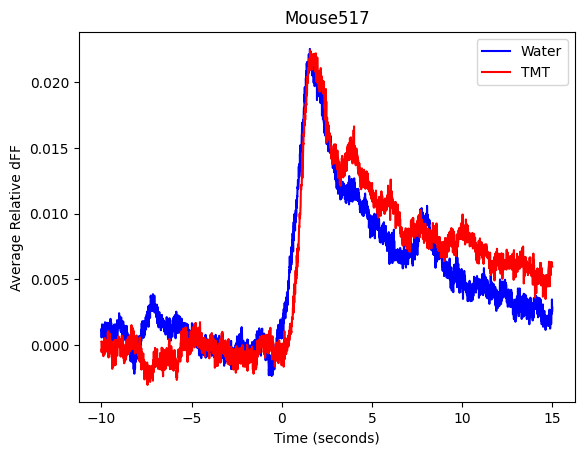

In [30]:
# Calculate the average trace for water and TMT
average_trace_water = np.mean(trace_data_matrix_water, axis=0)
average_trace_tmt = np.mean(trace_data_matrix_tmt, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water, label='Water', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt, label='TMT', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse517')
plt.legend()
plt.show()

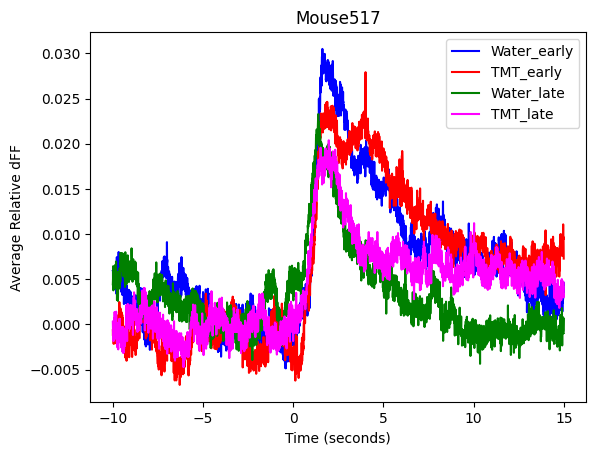

In [31]:
# Calculate the average trace for water and TMT
average_trace_water_early = np.mean(trace_data_matrix_water[0:4,:], axis=0)
average_trace_tmt_early = np.mean(trace_data_matrix_tmt[0:4,:], axis=0)
average_trace_water_late = np.mean(trace_data_matrix_water[10:14,:], axis=0)
average_trace_tmt_late = np.mean(trace_data_matrix_tmt[10:14,:], axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_early, label='Water_early', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_early, label='TMT_early', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_late, label='Water_late', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_late, label='TMT_late', color='magenta')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse517')
plt.legend()
plt.show()

### Process single PPD file

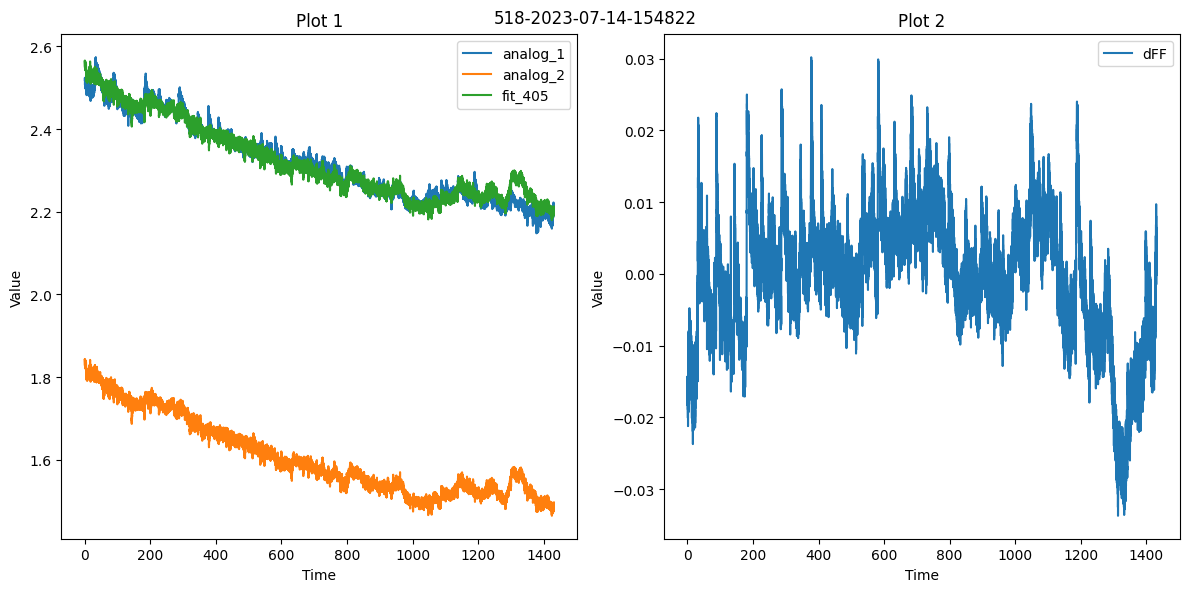

In [32]:
# Define the PPD file path
ppd_file_path = r'H:\fp_test\innate_fear\518-2023-07-14-154822.ppd'

# Extract the filename without the extension
filename = os.path.splitext(os.path.basename(ppd_file_path))[0]

# Load the data from the CSV file
data = import_ppd(ppd_file_path, low_pass=20, high_pass=0.001)

# Convert sample index to time vector
time = np.arange(len(data['analog_1'])) / 130

# http://dx.doi.org/10.1016/j.cell.2015.07.014
# dFF using 405 fit as baseline
reg= np.polyfit(data['analog_2'], data['analog_1'], 1) # ch1 is 465nm, ch2 is 405nm 
fit_405=reg[0]*data['analog_2']+reg[1]
dFF=(data['analog_1']-fit_405)/fit_405 #this gives deltaF/F
data['fit_405']=fit_405
data['dFF']=dFF

# Create the figure and subplots
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Plot 1
ax1.plot(time, data['analog_1'], label='analog_1')
ax1.plot(time, data['analog_2'], label='analog_2')
ax1.plot(time, data['fit_405'], label='fit_405')

# Set plot 1 properties
ax1.set_xlabel('Time')
ax1.set_ylabel('Value')
ax1.set_title('Plot 1')
ax1.legend()

# Plot 2
ax2.plot(time, data['dFF'], label='dFF')

# Set plot 2 properties
ax2.set_xlabel('Time')
ax2.set_ylabel('Value')
ax2.set_title('Plot 2')
ax2.legend()

# Adjust spacing between subplots
plt.tight_layout()

# Set the figure title
fig.suptitle(filename)

# Save the figure as PNG with 300 dpi
save_path = os.path.join(os.path.dirname(ppd_file_path), filename + '.png')
fig.savefig(save_path, dpi=300)

# Display the plots
plt.show()


In [33]:
data = {
    'UniBe006': 
            {'Stim': [0, 1, 0, 1, 0, 1, 0, 0, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1], 
             'Time': ['00:30', '01:25', '02:22', '03:00', '03:46', '04:45', '05:44', '06:16', '06:47', '07:19', 
                    '08:07', '08:53', '09:39', '10:30', '11:21', '12:06', '12:38', '13:16', '14:08', '14:57', 
                    '15:48', '16:40', '17:26', '18:04', '18:56', '19:49', '20:29', '21:22', '22:22', '23:17']}
}

stim_data = data['UniBe006']['Stim']
time_stamps = data['UniBe006']['Time']
sampling_rate = 130

def time_stamp_to_seconds(time_stamp):
    minutes, seconds = time_stamp.split(':')
    return int(minutes) * 60 + int(seconds)

water_indexes = [i for i, stim in enumerate(stim_data) if stim == 0]
tmt_indexes = [i for i, stim in enumerate(stim_data) if stim == 1]

water_time_stamps = [time_stamps[i] for i in water_indexes]
tmt_time_stamps = [time_stamps[i] for i in tmt_indexes]

water_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in water_time_stamps]
tmt_data_indexes = [int(time_stamp_to_seconds(time_stamp) * sampling_rate) for time_stamp in tmt_time_stamps]

print("Water Indexes:", water_indexes)
print("Water Time Stamps:", water_time_stamps)
print("Water Data Indexes:", water_data_indexes)

print("TMT Indexes:", tmt_indexes)
print("TMT Time Stamps:", tmt_time_stamps)
print("TMT Data Indexes:", tmt_data_indexes)


Water Indexes: [0, 2, 4, 6, 7, 11, 12, 14, 16, 18, 22, 23, 24, 26, 28]
Water Time Stamps: ['00:30', '02:22', '03:46', '05:44', '06:16', '08:53', '09:39', '11:21', '12:38', '14:08', '17:26', '18:04', '18:56', '20:29', '22:22']
Water Data Indexes: [3900, 18460, 29380, 44720, 48880, 69290, 75270, 88530, 98540, 110240, 135980, 140920, 147680, 159770, 174460]
TMT Indexes: [1, 3, 5, 8, 9, 10, 13, 15, 17, 19, 20, 21, 25, 27, 29]
TMT Time Stamps: ['01:25', '03:00', '04:45', '06:47', '07:19', '08:07', '10:30', '12:06', '13:16', '14:57', '15:48', '16:40', '19:49', '21:22', '23:17']
TMT Data Indexes: [11050, 23400, 37050, 52910, 57070, 63310, 81900, 94380, 103480, 116610, 123240, 130000, 154570, 166660, 181610]


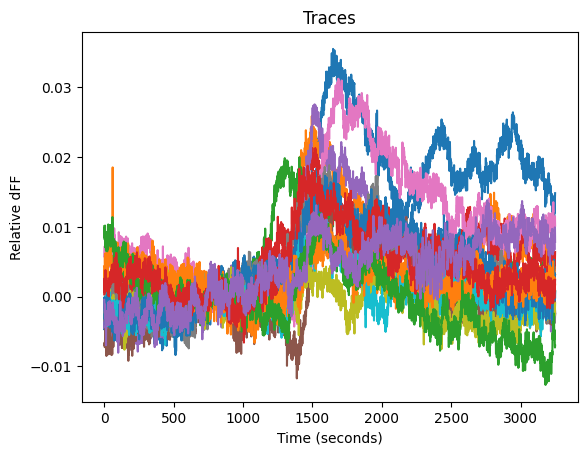

In [34]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in water_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_water = np.array(trace_data_matrix)


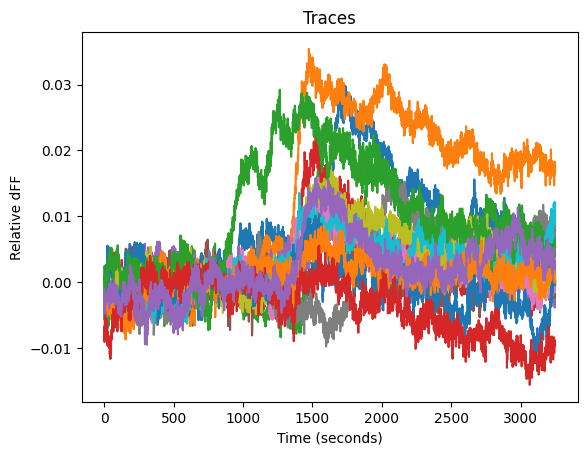

In [35]:
trace_duration = 5  # 5 seconds before and 30 seconds after each data index
sampling_rate = 130

# Convert trace duration from seconds to data points
trace_duration_points = trace_duration * sampling_rate

# Create an empty matrix to store trace data
trace_data_matrix = []

# Plotting all traces
fig, ax = plt.subplots()

for index in tmt_data_indexes:
    start = int(index - pre_start * sampling_rate)
    end = int(index + post_start * sampling_rate)
    trace_data = dFF[start:end]
    time = np.arange(start, end) / sampling_rate

    # Calculate the baseline value
    baseline_start = int(index - 5 * sampling_rate)
    baseline_end = int(index - 3 * sampling_rate)
    baseline = np.mean(dFF[baseline_start:baseline_end])

    # Compute the relative trace data
    relative_trace_data = trace_data - baseline

    ax.plot(relative_trace_data)

    # Append relative_trace_data to the matrix
    trace_data_matrix.append(relative_trace_data)

ax.set_xlabel('Time (seconds)')
ax.set_ylabel('Relative dFF')
ax.set_title('Traces')
plt.show()

# Convert trace_data_matrix to a NumPy array
trace_data_matrix_tmt = np.array(trace_data_matrix)


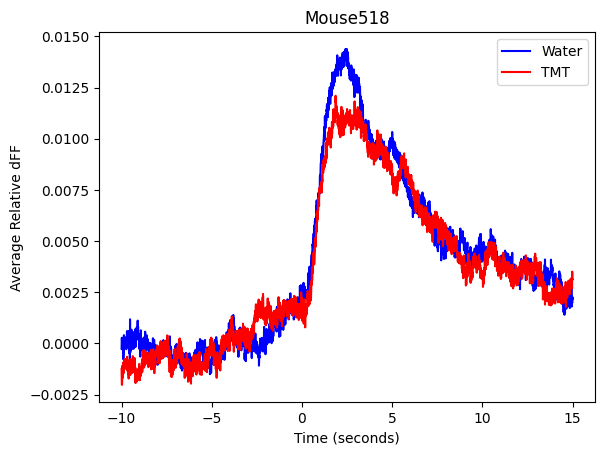

In [36]:
# Calculate the average trace for water and TMT
average_trace_water = np.mean(trace_data_matrix_water, axis=0)
average_trace_tmt = np.mean(trace_data_matrix_tmt, axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water, label='Water', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt, label='TMT', color='red')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse518')
plt.legend()
plt.show()

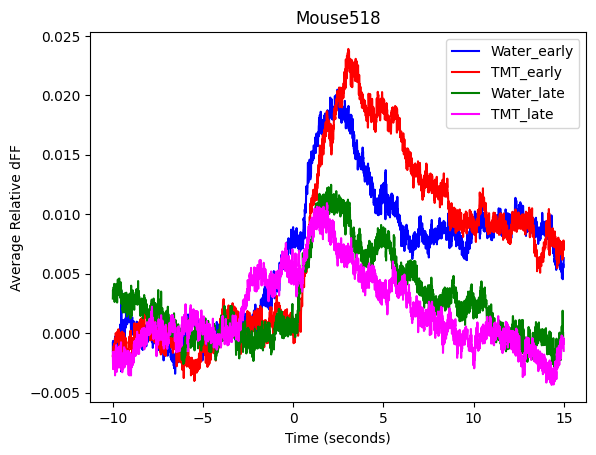

In [37]:
# Calculate the average trace for water and TMT
average_trace_water_early = np.mean(trace_data_matrix_water[0:4,:], axis=0)
average_trace_tmt_early = np.mean(trace_data_matrix_tmt[0:4,:], axis=0)
average_trace_water_late = np.mean(trace_data_matrix_water[10:14,:], axis=0)
average_trace_tmt_late = np.mean(trace_data_matrix_tmt[10:14,:], axis=0)

plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_early, label='Water_early', color='blue')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_early, label='TMT_early', color='red')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_water_late, label='Water_late', color='green')
plt.plot(np.arange(-pre_start, post_start, 1/sampling_rate), average_trace_tmt_late, label='TMT_late', color='magenta')
plt.xlabel('Time (seconds)')
plt.ylabel('Average Relative dFF')
plt.title('Mouse518')
plt.legend()
plt.show()